In [124]:
"""
Python function to estimate derivatives from noisy data based on
Rick Chartrand's Total Variation Regularized Numerical
Differentiation (TVDiff) algorithm.
"""


import jax.numpy as jnp
from jax import jit
import numpy as np
import matplotlib.pyplot as plt


# Defining some methods of differentiating our data
def difference(data):
    """Finite difference of data"""

    # Writing the difference as a linear operator
    diagonal = jnp.eye(data.shape[0]-1)
    padding = jnp.zeros((data.shape[0]-1, 1))
    matrix1 = jnp.hstack((diagonal, padding))
    matrix2 = jnp.hstack((padding, diagonal))
    differential_operator = matrix2 - matrix1

    return jnp.einsum('ij, j -> i', differential_operator, data)


def difference_quotient(xdata, ydata, jitter=0):
    """Finite difference quotient of xdata and ydata"""

    dx = difference(xdata)
    dy = difference(ydata)

    if jitter > 0:
        dx = jnp.sqrt(dx**2 + jitter) # jitter to prevent division by zero
    return dy/dx


def symmetric_difference_quotient(xdata, ydata, jitter=0):
    """Symmetric finite difference quotient is more stable"""
    diagonal = jnp.eye(xdata.shape[0]-2) # Get rid of
    padding = jnp.zeros((xdata.shape[0]-2, 2))
    matrix1 = jnp.hstack((diagonal, padding))
    matrix2 = jnp.hstack((padding, diagonal))
    D = matrix2 - matrix1

    dx = jnp.einsum('ij, j -> i', D, xdata)
    dy = jnp.einsum('ij, j -> i', D, ydata)

    if jitter > 0:
        dx = jnp.sqrt(dx**2 + jitter) # jitter to prevent division by zero
    return dy/dx


def grad_regulator(dydx, jitter=1e-5):
    """Penalty for large fluctuations in the derivative"""
    du = difference(dydx) # Second derivative of the data
    s = du / jnp.sqrt(du**2 + jitter)
    ds = difference(s)
    ds = jnp.insert(ds, 0, s[0])
    ds = jnp.append(ds, -s[-1])
    return ds


def grad_loss(dydx, data, info):
    """Gradient of the loss function"""
    x, y = data
    A, alph, jitter = info
    residual = jnp.einsum('ij, j -> i', A, dydx) - (y[:-1] - y[0])
    return jnp.einsum('ij, j -> i', A.T, residual) - alph * grad_regulator(dydx, jitter)


grad_loss_jit = jit(grad_loss)


def generate_A_matrix(x):
    """Generates the A matrix, which contstruct the integral to recover the function from the derivative"""
    dt = np.array(difference(x))
    n = dt.shape[0]
    t = x[:-1]
    A = np.zeros((n,n))
    for i in range(n):
        for j in range(n-1):
            if (x[i] > t[j]) and (x[i] < t[j+1]):
                A[i,j] = x[i] - t[j]
            elif t[j+1] <= x[i]:
                A[i,j] = t[j+1] - t[j]
            else:
                pass

    return jnp.asarray(A)


# Call this function to perform TVRD on (xdata, ydata)
def tvrd(xdata, ydata, itern=10000, alph=0.2, ep=0.001, lr=1e-2):
    """
    Estimate derivatives from noisy data based using the Total
    Variation Regularized Numerical Differentiation (TVDiff)
    algorithm.

    Parameters
    ----------
    xdata : jax ndarray
        One-dimensional array containing series the horizontal axis points

    ydata : jax ndarray
        One-dimensional array containing series data to be
        differentiated.

    itern : int
        Number of iterations to run the main loop.

    alph : float
        Regularization parameter.  This is the main parameter
        to fiddle with.  Start by varying by orders of
        magnitude until reasonable results are obtained.  A
        value to the nearest power of 10 is usally adequate.
        No default value.  Higher values increase
        regularization strenght and improve conditioning.

    ep : float, optional
        Parameter for avoiding division by zero.  Default value
        is 1e-6.  Results should not be very sensitive to the
        value.  Larger values improve conditioning and
        therefore speed, while smaller values give more
        accurate results with sharper jumps.

    lr : float, optional
        Learning rate parameter for gradient descent.


    Returns
    -------
    xdata : ndarray
        X data.  Due to different grid assumptions, it has
        popped the left and right ends of the data.

    ydata : ndarray
        Y data.  Due to different grid assumptions, it has
        popped the left and right ends of the data.

    x : ndarray
        Estimate of the regularized derivative of data.
        Due to different grid assumptions, it has
        popped the left and right ends of the data.

    Au : ndarray
        Estimate of the regularized Y data.  Due to
        different grid assumptions, it has
        popped the left and right ends of the data.
    """

    A = generate_A_matrix(xdata)
    dydx = difference_quotient(xdata, ydata)
    data = xdata, ydata

    info = A, alph, ep
    u = dydx
    for idx in range(itern):
        u -= lr * grad_loss_jit(u, data, info)

    Au = jnp.einsum('ij, j -> i', A, u) + ydata[0]

    return xdata, ydata, u, Au


# Simulated Data

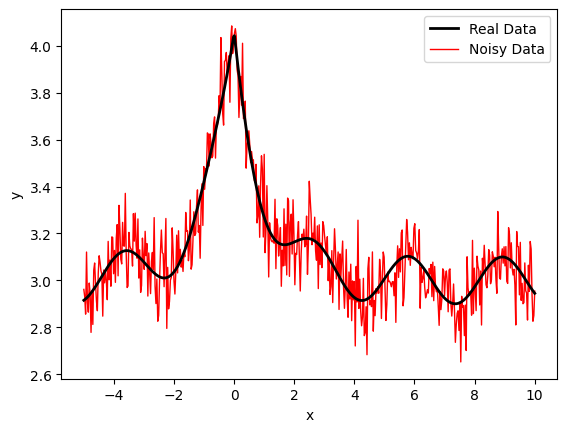

In [125]:
a, b, n =-5, 10, 500
xdata = np.linspace(a,b,n+1)

# Function that adds noise
def f(x):
    return np.exp(-np.abs(x))+0.1*np.cos(2*x+1) + 3

ydata_real = f(xdata)
# Generate noisy data
eta = 0.1
ydata = f(xdata) + eta * np.random.randn(np.size(xdata))

# Plot the noisy data
plt.plot(xdata, ydata_real, label='Real Data',zorder=1, lw=2, c='k')
plt.plot(xdata, ydata, label='Noisy Data', zorder=0, lw=1, c='r')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [126]:
# Run the TVRD method
_, _, u, Au = tvrd(xdata, ydata, itern=5000, alph=1, ep=1e-2, lr=5e-3)


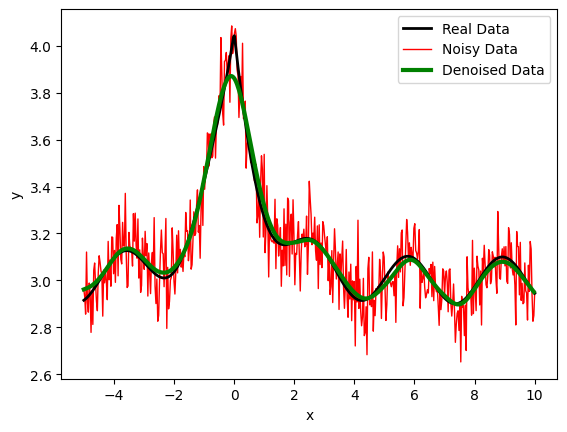

In [127]:
# Plot the data
plt.plot(xdata, ydata_real, label='Real Data',zorder=1, lw=2, c='k')
plt.plot(xdata, ydata, label='Noisy Data', zorder=0, lw=1, c='r')
plt.plot(xdata[:-1], Au, label='Denoised Data', zorder=3, lw=3, c='g')
#plt.plot(xdata[:-1], u, label='Denoised Derivative')
plt.legend()

plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.show()

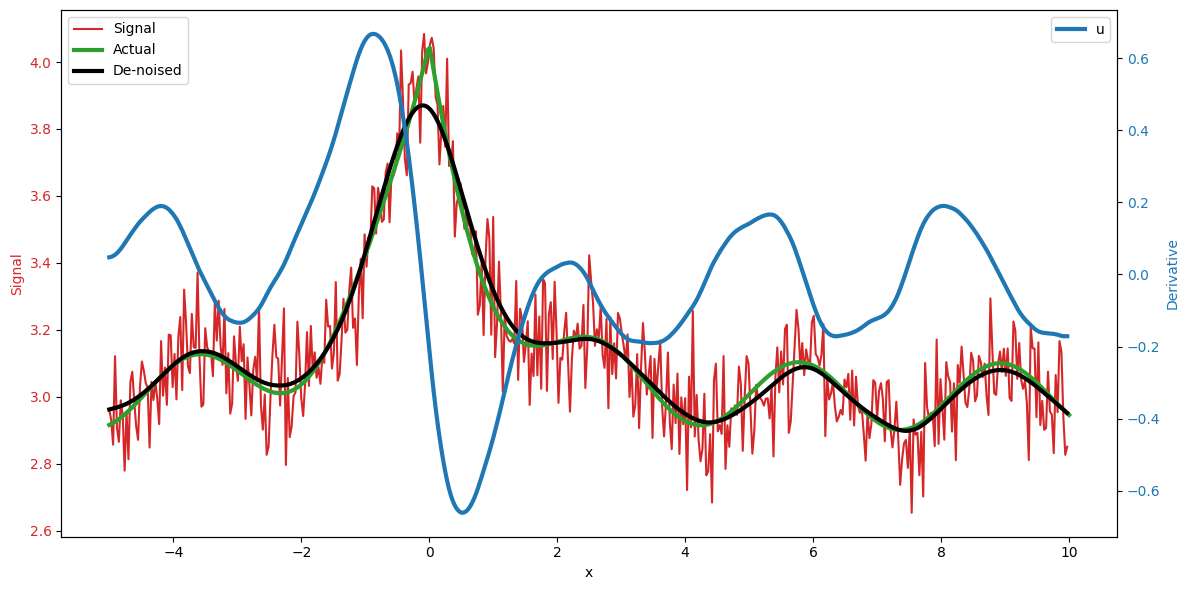

In [128]:
# Plot

fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:red'
ax1.set_xlabel('x')
ax1.set_ylabel('Signal', color=color)
ax1.plot(xdata[:-1], ydata[:-1], color=color, label='Signal')
ax1.plot(xdata, ydata_real, color='tab:green', lw=3, label='Actual')
ax1.plot(xdata[:-1], Au, color='k', lw=3, label='De-noised')
ax1.tick_params(axis='y', labelcolor=color)
plt.legend(loc='upper left')


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Derivative', color=color)  # we already handled the x-label with ax1
ax2.plot(xdata[:-1], u, color=color, lw=3, label='Denoised')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend('upper right')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

# Stock Data

In [129]:
import pandas as pd
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [130]:
data_import = pd.read_pickle('/content/gdrive/MyDrive/datasets/stock_scrape.pkl')


df = data_import['Adj Close']
df = df.dropna(axis='columns')

# Filter out data
df = df.loc['2022-06-01':]

cols = df.columns.to_list()
t = df.index.values
y = df[cols].values
df.head()

,EEM,EFA,EWJ,EWZ,FXI,GDX,IWM,QQQ,SLV,SPY,TZA,UNG,VWO,XLF,XLI
Date,,,,,,,,,,,,,,,
2022-06-01,40.269909,65.463829,55.775539,29.407070,29.808445,30.939705,179.318329,302.050018,20.129999,398.250427,37.075016,29.790001,40.314426,33.678051,91.199173
2022-06-02,40.964218,66.824707,56.346558,29.775709,30.668755,32.265137,183.697617,310.321869,20.590000,405.834564,34.425423,28.790001,41.039803,34.141247,92.943298
2022-06-03,40.298443,65.870201,55.175491,29.524366,30.129879,31.500839,182.043243,302.247437,20.230000,399.174103,35.292568,28.959999,40.398125,33.649097,92.584793
2022-06-06,40.517197,66.134811,55.475517,29.214375,30.961832,31.171900,182.831512,303.254211,20.370001,400.389557,34.907173,31.730000,40.621315,33.745602,92.972366
2022-06-07,40.640846,66.333282,55.649723,28.728447,31.434528,31.471813,185.780228,305.870056,20.520000,404.230164,33.240337,31.719999,40.825909,34.006142,94.222336


In [131]:
data_y = np.log(y[:,9])
data_x = np.array(range(t.shape[0]))

In [132]:
_, _, u, Au = tvrd(data_x, data_y, itern=10000, alph=5e-1, ep=10e-8, lr=1e-5)

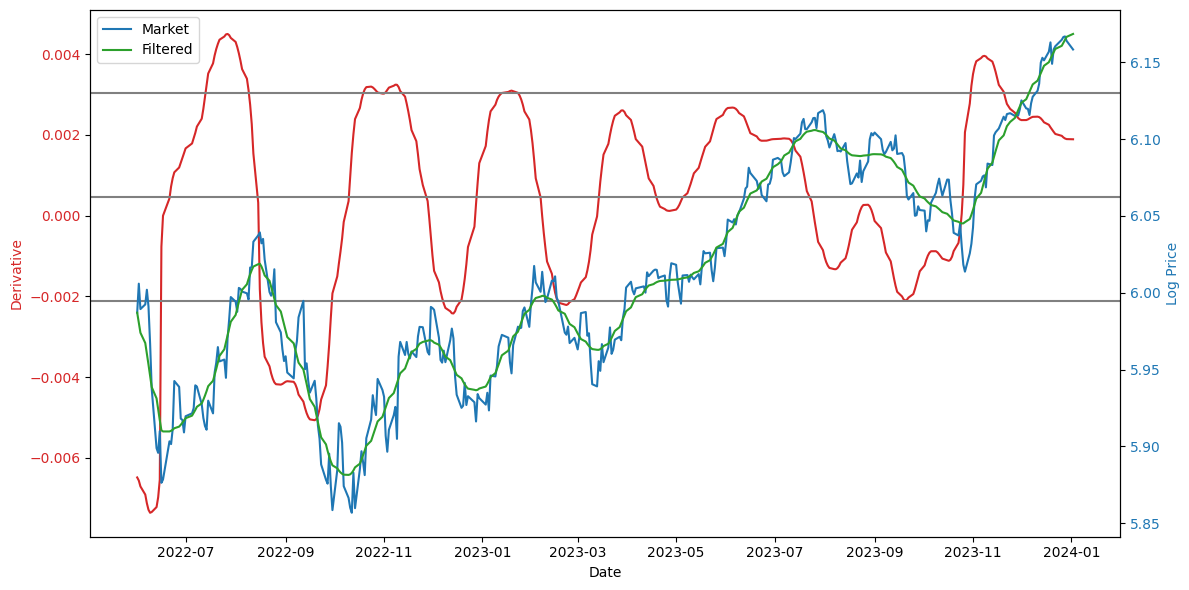

In [134]:
# Plot

fig, ax1 = plt.subplots(figsize=(12, 6))
mean, sigma = np.mean(u), np.std(u)

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Derivative', color=color)
ax1.plot(t[:-1], u, color=color, label='Derivative')
ax1.tick_params(axis='y', labelcolor=color)

ax1.axhline(y = mean, color = 'grey', linestyle = '-')
ax1.axhline(y = mean+sigma, color = 'grey', linestyle = '-')
ax1.axhline(y = mean-sigma, color = 'grey', linestyle = '-')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Log Price', color=color)  # we already handled the x-label with ax1
ax2.plot(t[:-1], data_y[:-1], color=color, label='Market')
ax2.plot(t[:-1], Au, color='tab:green', label='Filtered')
ax2.tick_params(axis='y', labelcolor=color)

plt.legend()
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()